In [51]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
np.random.seed(1231)

In [4]:
df = pd.read_excel("data/nph_3069_sm_tables2.xls", sheet_name="Sheet1",
                   header=5, skipfooter=5, usecols="A:B,D:P,R:AC") \
    .fillna(0) \
    .drop(0)   \
    .rename(columns={"Unnamed: 0": "Tree", "Unnamed: 1": "Cohort"})
df = df.astype({k: int for k in df.columns[2:]})
df["Tree"] = df["Tree"].replace("a|b", "", regex=True).astype(int)
df

Tree Cohort  VES-01  VES-02  VES-03  VES-04  VES-05  VES-06  VES-07  \
1     37      1       0       0       0       0       0       0       0   
2     38      1       0       0       0       0       0       0       0   
3     39      1       0       0       0       0       0       0       0   
4     40      1       0       0       0       0       0       0       0   
5     42      1       0       0       0       0       0       0       0   
..   ...    ...     ...     ...     ...     ...     ...     ...     ...   
74    64      4       3       0       0       0       0       0       0   
75    83      4       0       1       0       0       0      11       3   
76    85      4       0       0       1       0       0       1       0   
77    86      4       3       0       0       0       0       2       0   
78    90      4       0       1       0       0       0       0       1   

    VES-08  ...  VIN-03  VIN-04  VIN-05  VIN-06  VIN-07  VIN-08  VIN-09  \
1        0  ...       0       0       0       0       0       0       0   
2        0  ...       0       0       0       0       0       0       0   
3        0  ...       0       0       0       0       0       0       0   
4        0  ...       1       0       0       0       0       0       0   
5        0  ...       0       0       0       0       0       0       0   
..     ...  ...     ...     ...     ...     ...     ...     ...     ...   
74       0  ...       0       0       0       0       0       0       0   
75       0  ...       2       0       0       0       0       0       0   
76       0  ...       0       0       1       0       0       0       0   
77       0  ...       0       0       0       0       0       0       0   
78       0  ...       0       0       1       0       0       0       0   

    VIN-10  VIN-11  VIN-12  
1        0       0       0  
2        0       0       0  
3        0       0       0  
4        0       0       0  
5        0       0       0  
..     ...     ...     ...  
74       0       0       0  
75       0       0       0  
76       0       0       0  
77       0       0       0  
78       0       0       0  

[78 rows x 27 columns]

In [27]:
#Initialize graph
B = nx.Graph()

# add genets nodes
B.add_nodes_from(df.columns[2:], bipartite=0)

#Cohort-diameter map
cohort_diameter_map = {1: (0.7, 0.68), 2: (8.1, 5.2), 3: (24.5, 6.2), 4: (46.4, 5.3)}

def calc_carbon(diameter, max_diameter, stress_level=0):
    fraction = diameter/max_diameter
    carbon = np.tanh((fraction - 0.5)*np.pi*2) + stress_level
    return carbon
    
# add tree nodes
for _, row in df.iterrows():
    mean, stdev = cohort_diameter_map[row["Cohort"]]
    B.add_node(row["Tree"], bipartite=1, cohort=row["Cohort"], diameter=abs(np.random.normal(mean, stdev)))

max_diameter = max(nx.get_node_attributes(B, "diameter").values())    

for node in B.nodes():
    if (B.nodes[node]["bipartite"] == 1):
        B.nodes[node]["carbon_value"] = calc_carbon(B.nodes[node]["diameter"], max_diameter)

edges = []
# add edges between genets and trees
for _, row in df.iterrows():
    for genet, n in row[2:].items():
        if n > 0:
            edges.append((genet, row["Tree"]))
            

            
B.add_edges_from(edges)
B.remove_nodes_from([x for x in B.nodes() if B.degree(x) == 0])
B.remove_nodes_from(("VES-11", 79)) # disconnected part

Trees: 55, genets: 24


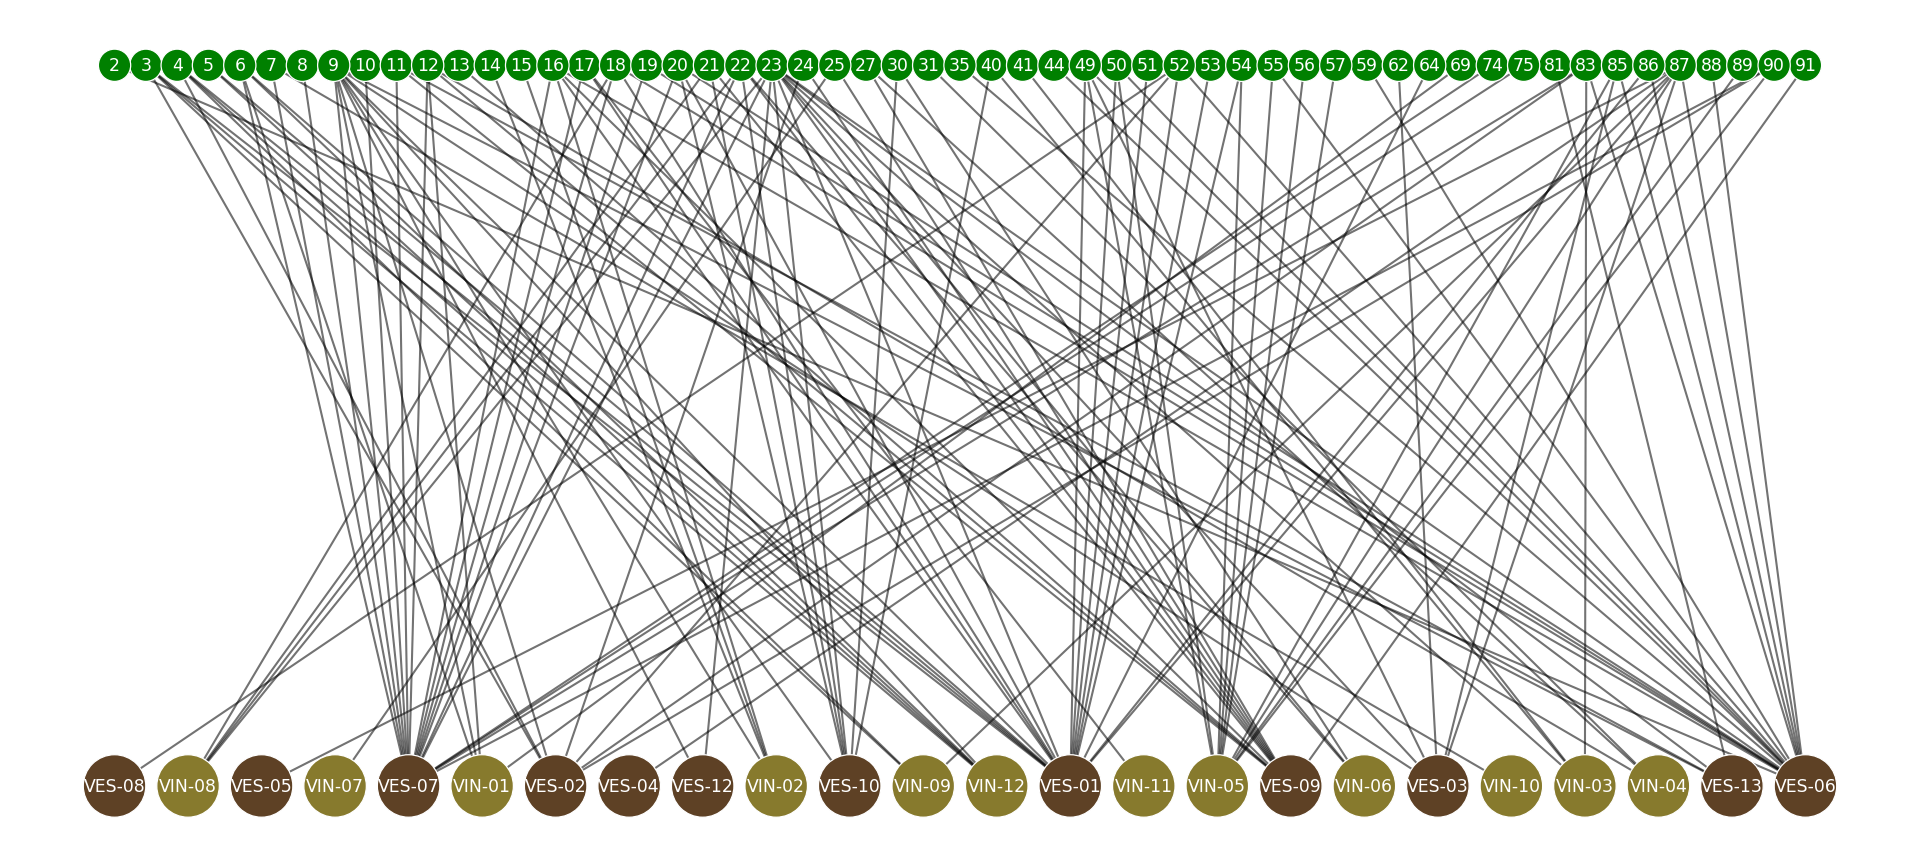

In [28]:
fungi, trees = bipartite.sets(B)
print(f"Trees: {len(trees)}, genets: {len(fungi)}")
pos = nx.bipartite_layout(B, trees, align="horizontal")

node_sizes = []
node_colors = []
for node in B.nodes:
    if B.nodes[node]["bipartite"] == 1:
        node_sizes.append(60)
        node_colors.append("green")
    else:
        node_sizes.append(225)
        if node[0:3] == "VES":
            node_colors.append("#5e4125")
        else:
            node_colors.append("#877a2d")

plt.figure(figsize=(8, 3.5), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(B, pos=pos, node_size=node_sizes, node_color=node_colors, linewidths=0.3, edgecolors="white")
nx.draw_networkx_labels(B, pos, font_color="white", font_size=4.15)
nx.draw_networkx_edges(B, pos, alpha=0.55, width=[0.5 for _ in range(len(B.nodes))])
plt.gca().set_axis_off()
plt.show()

Avg. degree: 19.490909090909092; Max degree: 47 (tree 23)


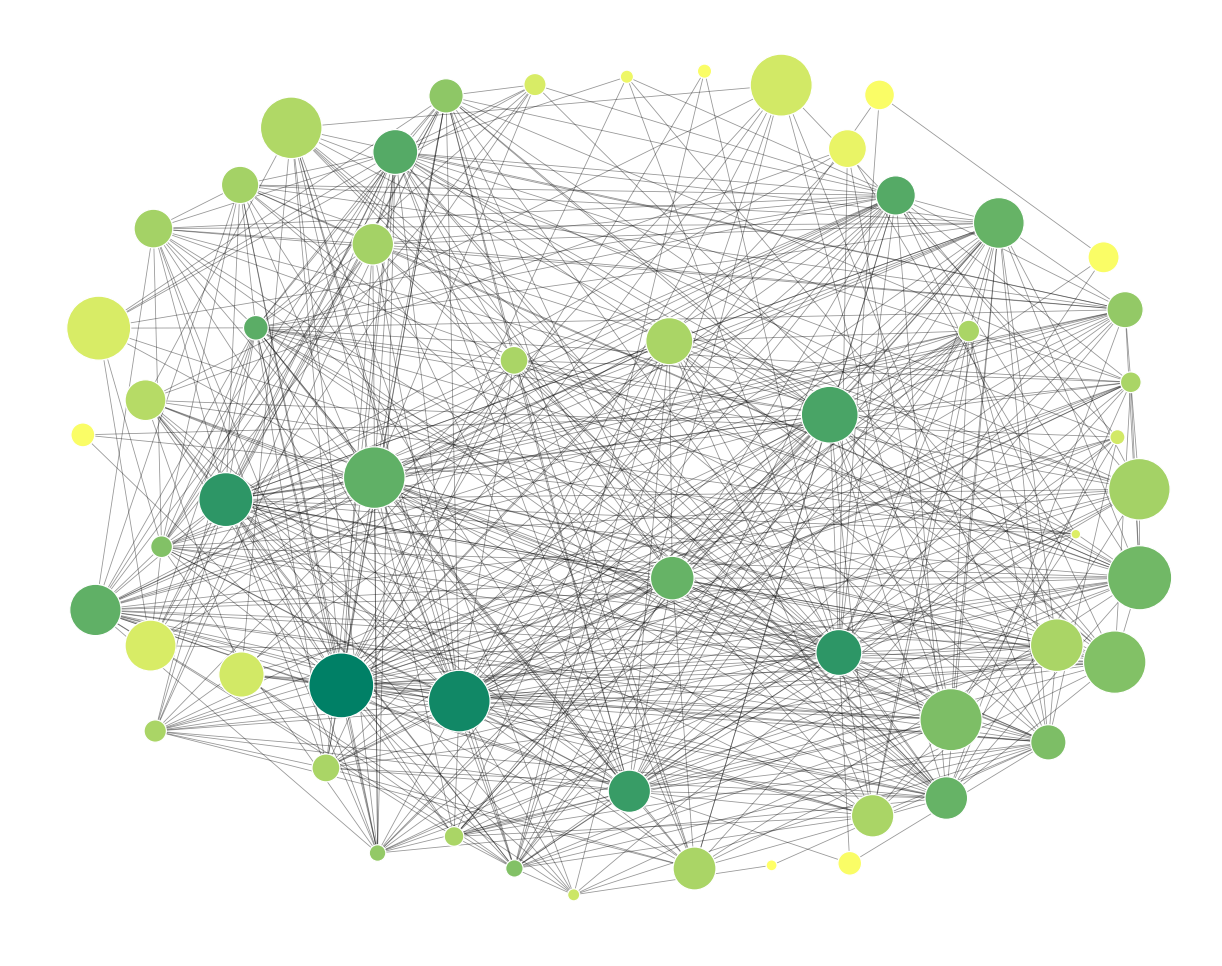

In [29]:
G = bipartite.weighted_projected_graph(B, trees)
degrees_dict = {n: d for n, d in G.degree()}
degrees = list(degrees_dict.values())
sorted_degrees = sorted(degrees_dict, key=degrees_dict.get)
print(f"Avg. degree: {np.average(degrees)}; Max degree: {np.max(degrees)} (tree {sorted_degrees[-1]})")
# print(nx.get_edge_attributes(G, "weight"))

pos = nx.spring_layout(G, k=3,seed=99192, weight=None)

node_sizes = []

for node in G.nodes:
    node_size = max(5, G.nodes[node]["diameter"]*5)
    node_sizes.append(node_size)

plt.figure(figsize=(5, 4), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=degrees,
                       edgecolors="white", linewidths=0.3, cmap=mpl.cm.summer_r)
#nx.draw_networkx_labels(G, pos, font_color="black", font_size=4.1)
nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))])
plt.gca().set_axis_off()
plt.show()

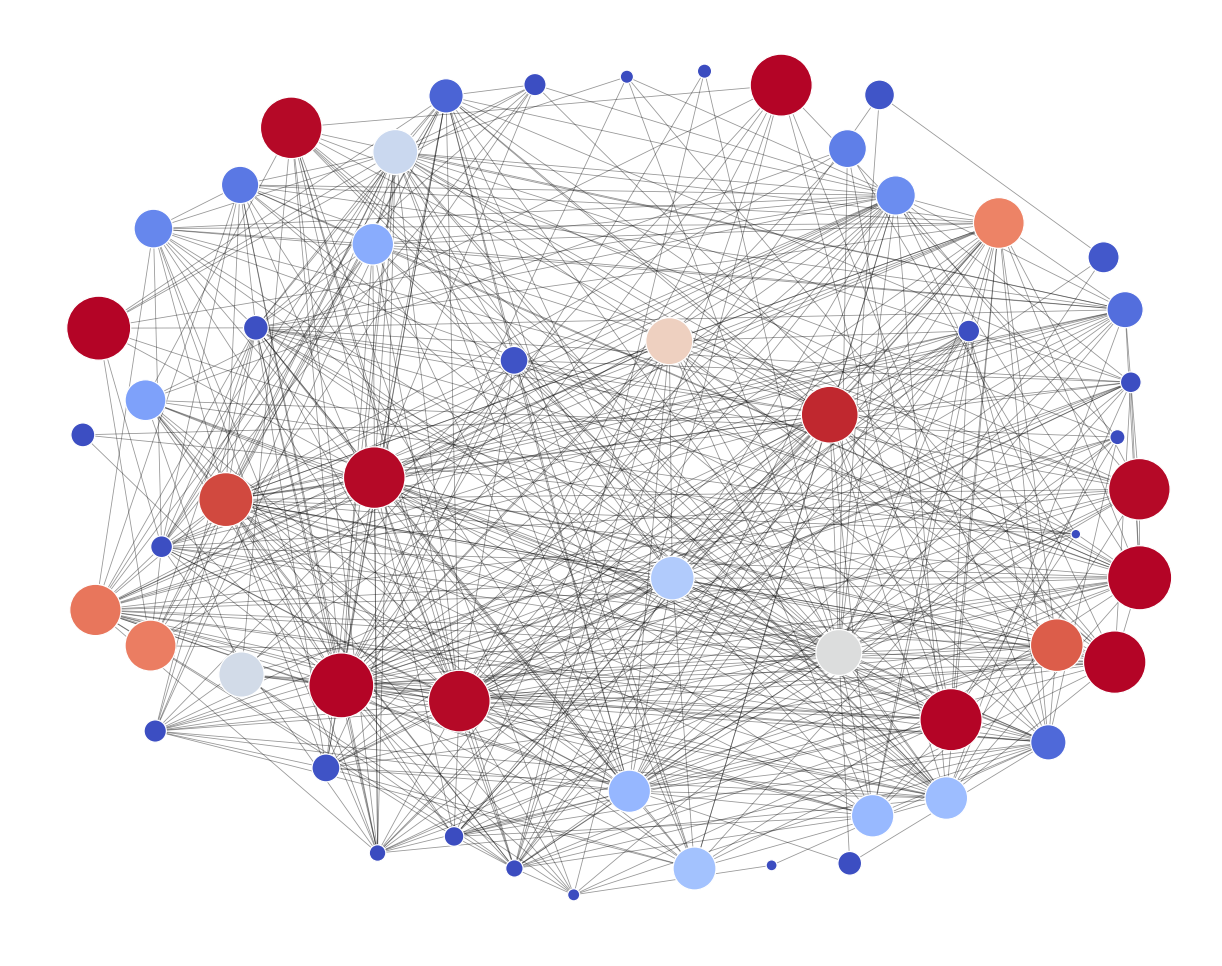

In [30]:
G = bipartite.weighted_projected_graph(B, trees)
degrees_dict = {n: d for n, d in G.degree()}
degrees = list(degrees_dict.values())
carbon_values = list(nx.get_node_attributes(G, "carbon_value").values())
sorted_degrees = sorted(degrees_dict, key=degrees_dict.get)

plt.figure(figsize=(5, 4), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=carbon_values,
                       edgecolors="white", linewidths=0.3, cmap=mpl.cm.coolwarm)
#nx.draw_networkx_labels(G, pos, labels = carbon_values, font_color="black", font_size=4.1)
nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))])
plt.gca().set_axis_off()
plt.show()

In [31]:
G.nodes

NodeView((2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 30, 31, 35, 40, 41, 44, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 62, 64, 69, 74, 75, 81, 83, 85, 86, 87, 88, 89, 90, 91))

In [32]:
def diffusion_dynamics(t, y, G, D_C, D_h, c3, N):
    carbon, hormone = y[:N], y[N:] # y has to be 1-dimensional :(
    carbon_next, hormone_next = np.zeros(len(carbon)), np.zeros(len(hormone))
    
    for i in range(N):
        node_idx = list(G.nodes)[i]
        node = G.nodes[node_idx]
        neighbors = G.neighbors(node_idx)
        
        for j in neighbors:
            neighbor_node_idx = list(G.nodes).index(j)
            
            neighbor_carbon = carbon[neighbor_node_idx]
            neighbor_hormone = hormone[neighbor_node_idx]
            
            carbon_next[i] += D_C*(neighbor_carbon - carbon[i]) - c3*carbon[i]**2*hormone[i]
            hormone_next[i] += D_h*(neighbor_hormone - hormone[i]) + c3*carbon[i]**2*hormone[i]
        
    return np.concatenate((carbon_next, hormone_next))

In [264]:
init_hormone = np.array(init_carbon)
init_hormone = -init_hormone
init_hormone[np.where(init_hormone < 0)] = 0

N = len(G.nodes)
t_range = (0, 2)
D_C = 0.2 # carbon diffusion coeff
D_h = 0.8 # hormone diffusion coeff
c3 = 0.01
sol = solve_ivp(diffusion_dynamics, t_range, init_carbon + init_hormone.tolist(), args=(G, D_C, D_h, c3, N),
                dense_output=True)

In [46]:
from scipy.integrate import solve_ivp

init_carbon = list(nx.get_node_attributes(G, "carbon_value").values())

init_hormone = np.array(init_carbon)
init_hormone = -init_hormone
init_hormone[np.where(init_hormone < 0)] = 0

N = len(G.nodes)
t_range = (0, 2)
D_C = 0.2 # carbon diffusion coeff
D_h = 0.8 # hormone diffusion coeff
c3 = 0.01
sol = solve_ivp(diffusion_dynamics, t_range, init_carbon + init_hormone.tolist(), args=(G, D_C, D_h, c3, N),
                dense_output=True)

# Baseline Model
The baseline network diffusion equation is

$$\dot{v}_i = \sum_{j = 1}^N A_{ji}\left(v_j - v_i\right),$$

where $A$ is the adjacency matrix for the network. Alternatively, we can phrase it as.

$$\dot{v}_i = \sum_{j \in \mathcal{N}(i)}A_{ji}\left(v_j - v_i\right).$$

The model behaviour we target is some agency from the plant -- we want it to be able ot push and pull at gradients at gradients on its own depending on its own nutrient availability.

# Two Transport Processes
We model two nutrient transport processes. Nutrients are available at two places at each node of the network:
- soil/roots ($r_i(t)$)
- in the plant body ($p_i(t)$)

The transport between roots of adjacent nodes is modelled as a diffusion process (called "soil transport"), and the 
uptake of the nutrients from the soil by the plant is governed by another transport process (called the "vascular 
transport") here.

$$\dot{r_i} = \sum_{j \in \mathcal{N}(i)}A_{ji}\left(r_j - r_i\right) - P_i(p_i)r_i$$
$$\dot{p_i} = P_i(p_i)r_i,$$

where $P_i(p_i)$ is a function that encodes information about the nutrient response of the plant. The hand-wavy
physical reasoning here is that nutrient transport through zylem and phloem is driven using a pressure gradient that is governed by the respiration processes in the plant in response to external stimuli (nutrient availability, temperature, humidity etc). So, $P_i(p_i)$ is parameterised by the properties of the plant in question, mostly age.

Suggested properties
- Proportional to root surface area, $$P_i(p_i) \propto \text{ diameter}^r$$, where $2 < r < 3$
- 

In [74]:
def get_neighbors(G, i):
    node_idx = list(G.nodes)[i]
    node = G.nodes[node_idx]
    return G.neighbors(node_idx)

def split(xs, N):
    return xs[:N], xs[N:]

def pressure_coefficient(r, p=1.0):
    return p + np.exp(-p*r)

# do I remember Haskell?
# what is S-combinator?
def diffusion_transport_dynamics(t, y, G, D_C, P, N, ps):
    """
    Bitch lambda calculus
    - P::float -> float -> float
    - ps::[]float
        list of second argument for P
    - N:: integer
        node count, which should be encoded in both `G` and `y`, but okay
    - D_C:: float
        diffusion coefficient
    """
    nutrient_root, nutrient_plant = split(y, N)
    
    n_r = len(nutrient_root)
    n_p = len(nutrient_plant)
    d_root = np.zeros(n_r) 
    d_plant = np.zeros(n_p)
    
    for i in range(N):
        neighbors = get_neighbors(G, i)
        
        rᵢ = nutrient_root[i]
        pᵢ = nutrient_plant[i]
        p = ps[i]
        
        pressure_transport = rᵢ * P(pᵢ, p=p)
        d_root[i] -= pressure_transport
        d_plant[i] += pressure_transport
        for j in neighbors:
            neighbor_node_idx = list(G.nodes).index(j)
            
            rⱼ = nutrient_root[neighbor_node_idx]
            pⱼ = nutrient_plant[neighbor_node_idx]
            
            d_root[i] += D_C*(rⱼ - rᵢ)
        
    return np.concatenate((d_root, d_plant))

In [75]:
plant_nutrients_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_nutrients_0 = np.random.uniform(low=0, high=1, size=len(plant_nutrients_0))
x0 = np.concatenate([root_nutrients_0, plant_nutrients_0])
ps = diameters = np.array(list(nx.get_node_attributes(G, "diameter").values()))
D_C = 0.2
N = len(G.nodes)
t_range = (0, 2)
sol = solve_ivp(diffusion_transport_dynamics,
                t_range, x0, args=(G, D_C, pressure_coefficient, N, ps),
                dense_output=True, method="LSODA")

In [76]:
time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

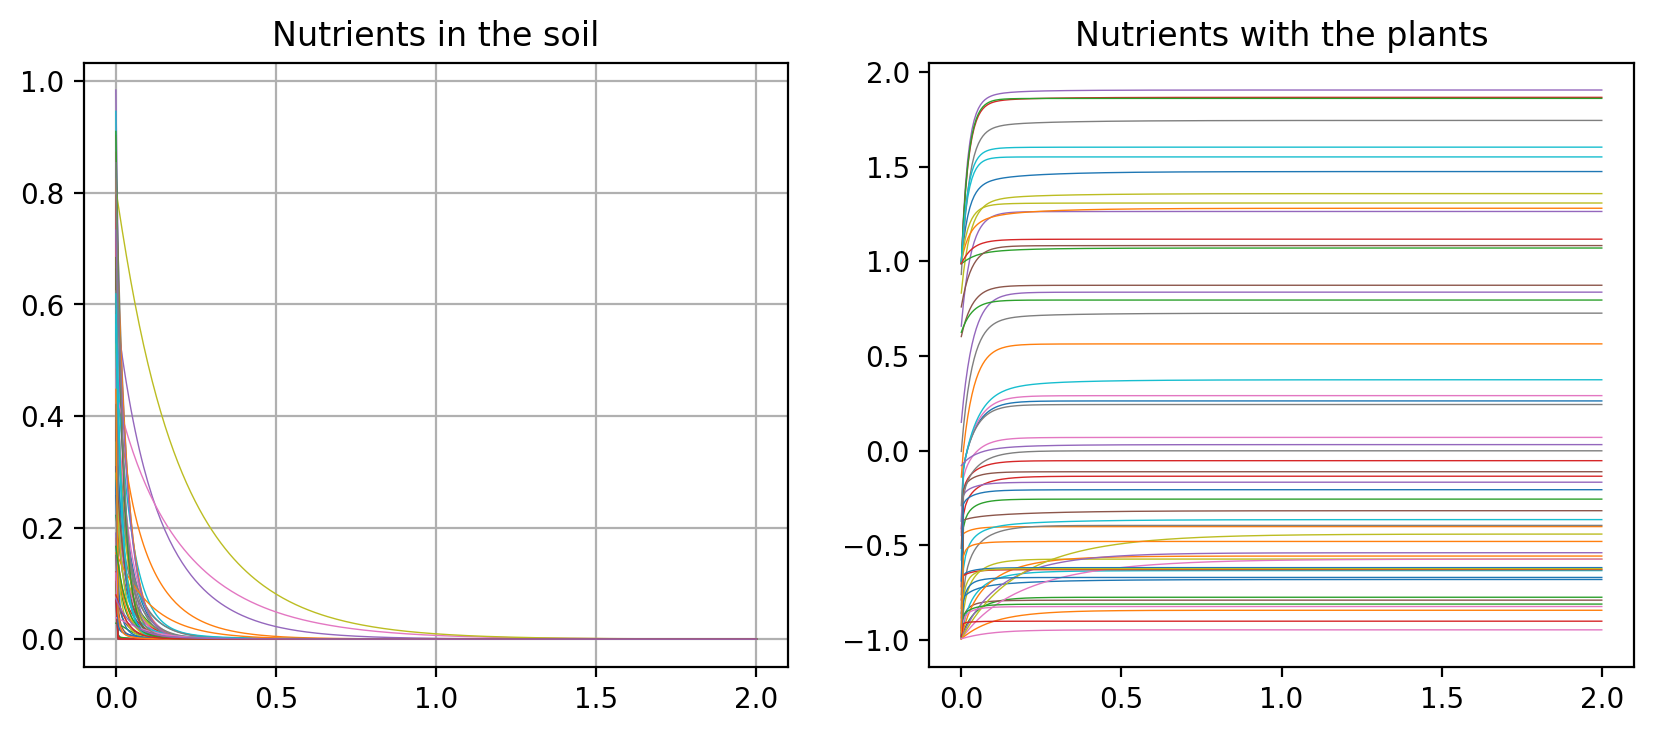

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

axes[0].set_title("Nutrients in the soil")
axes[0].grid()
for i in range(N):
    axes[0].plot(t, z[i], linewidth=0.5)
    
axes[1].set_title("Nutrients with the plants")
for i in range(N, 2*N):
    axes[1].plot(t, z[i], linewidth=0.5)

plt.show()

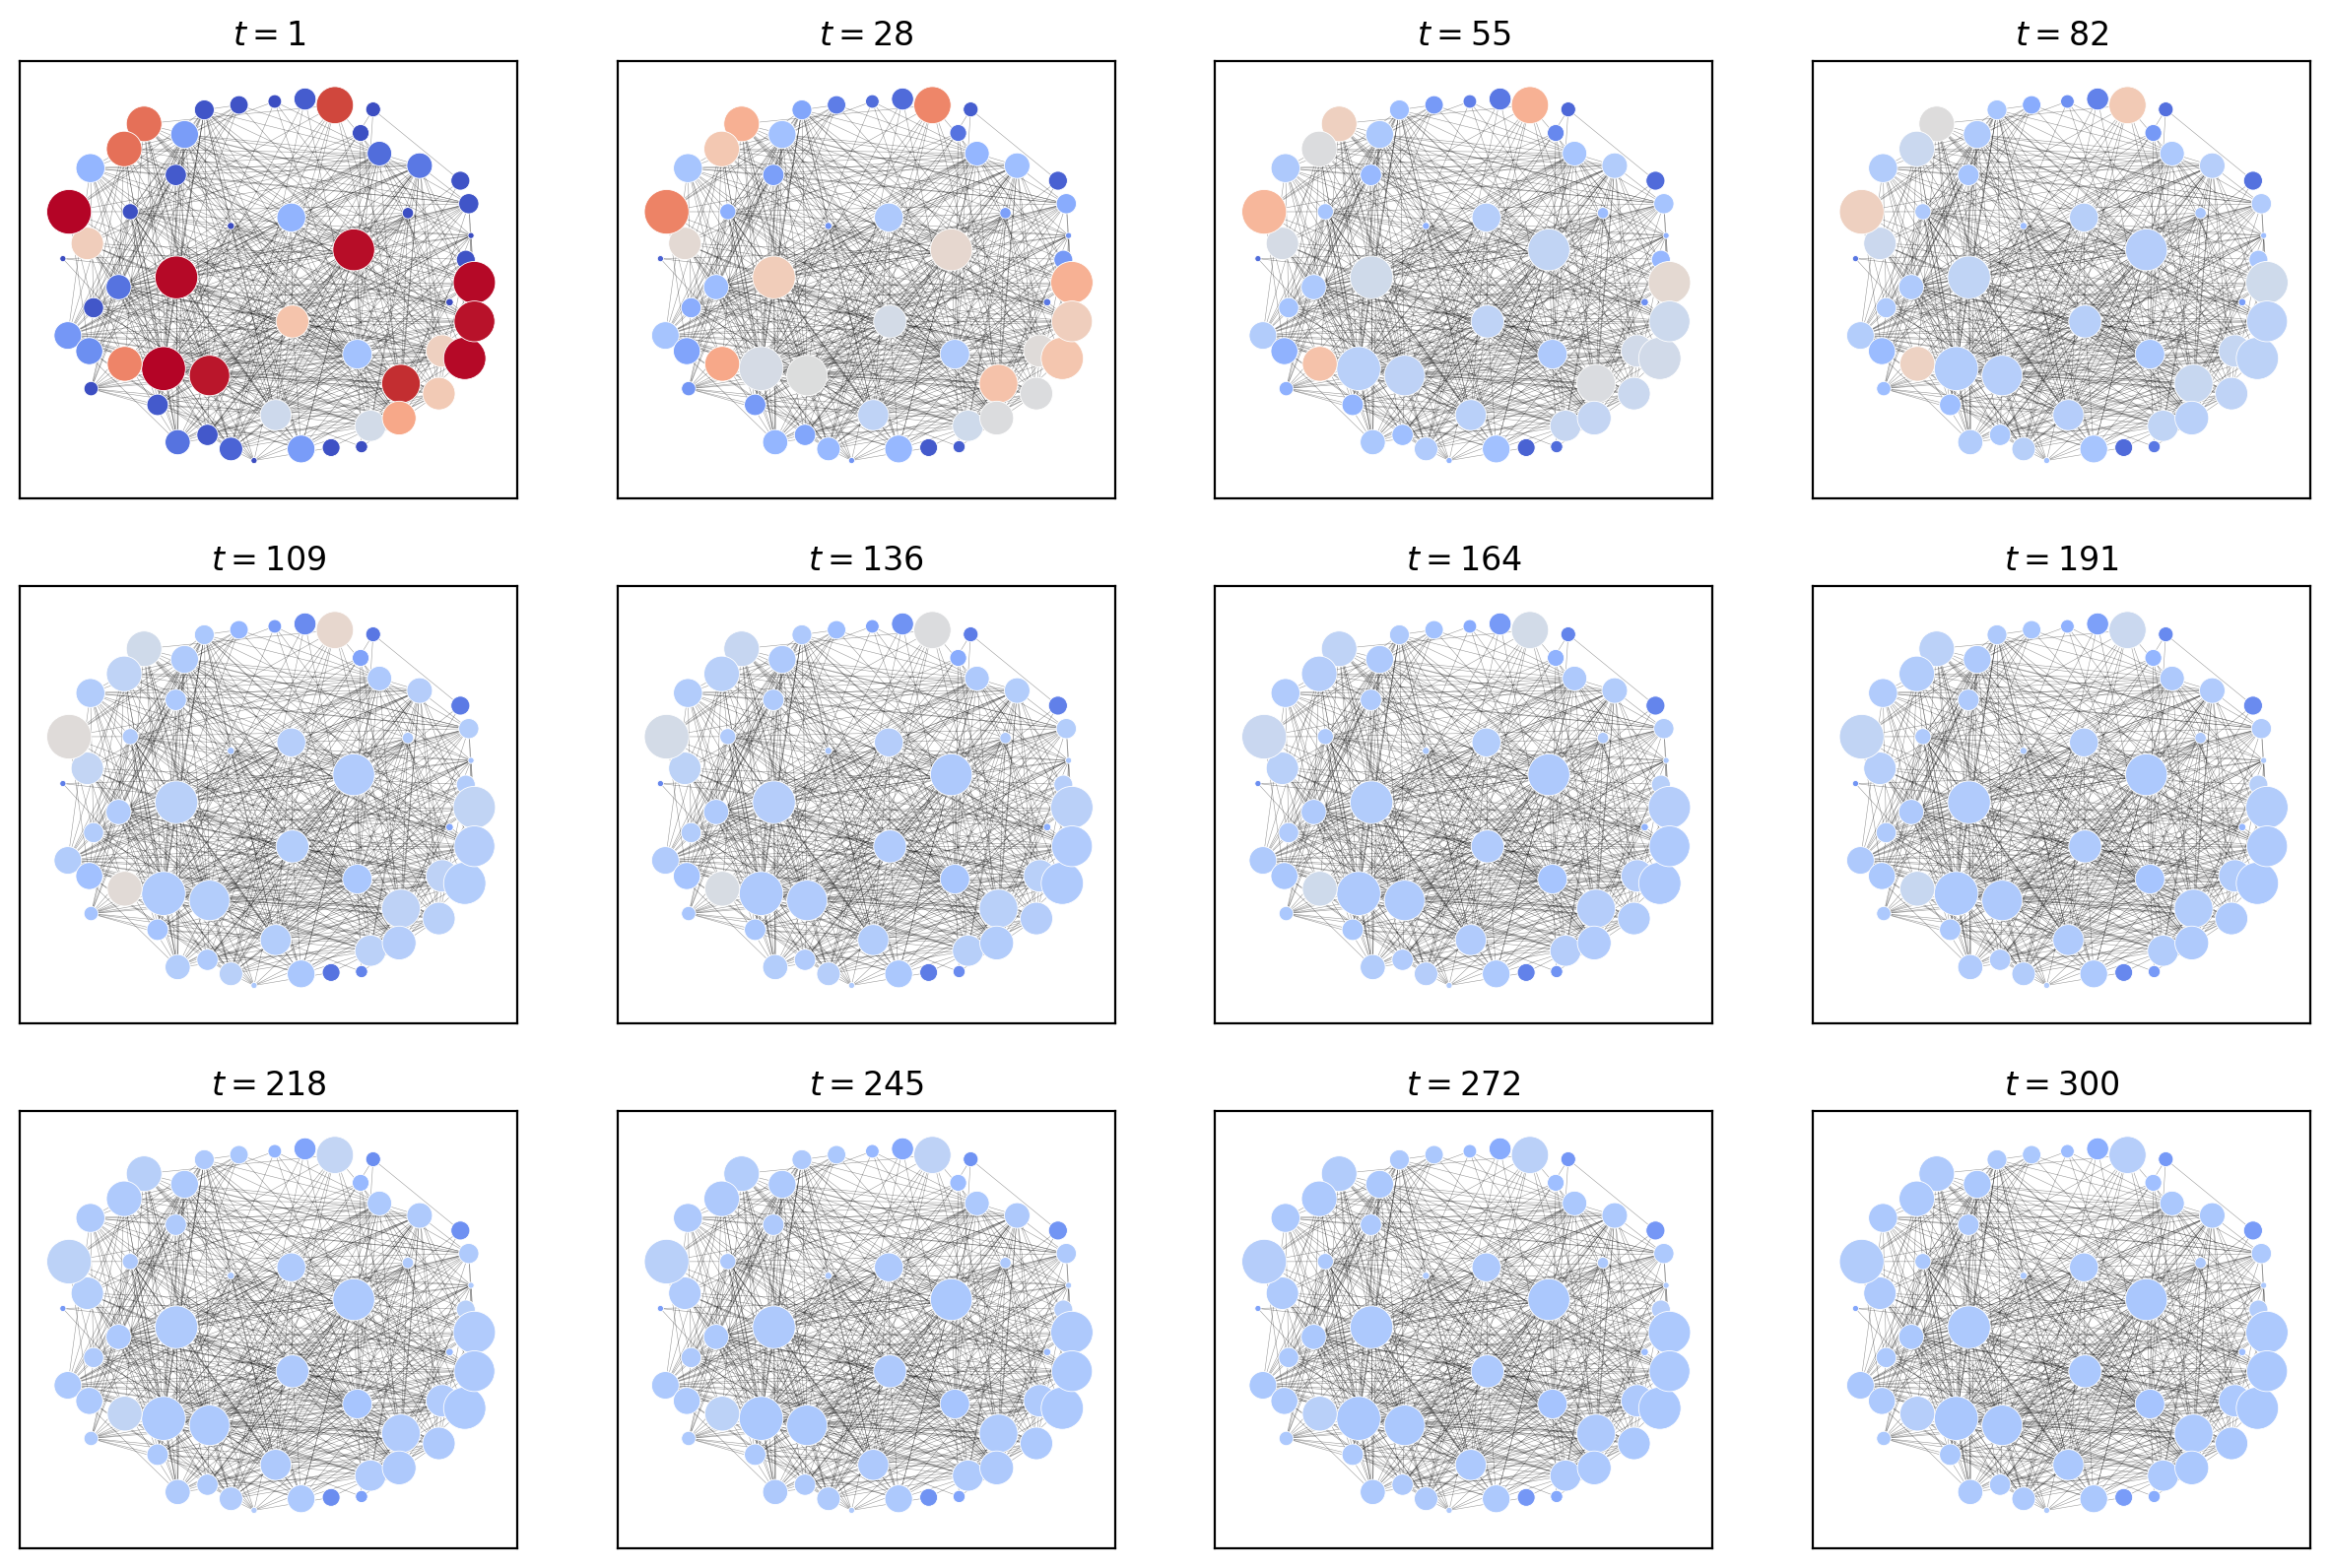

In [267]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), dpi=200)

steps = np.linspace(0, time_steps-1, 12, dtype=int)

for j, ax in enumerate(axes.flat):
    ax.set_title(f"$t = {steps[j] + 1}$")
    carbon_vals_t = z[:,steps[j]][:N]
    hormone_vals_t = z[:,steps[j]][N:]
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=carbon_vals_t,
                       edgecolors="white", linewidths=0.3, cmap=mpl.cm.coolwarm, ax=ax, vmin=-1, vmax=1)
    #nx.draw_networkx_labels(G, pos, labels = carbon_values, font_color="black", font_size=4.1)
    nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))], ax=ax)
    
plt.show()

/tmp/ipykernel_3180375/2609373657.py:6: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


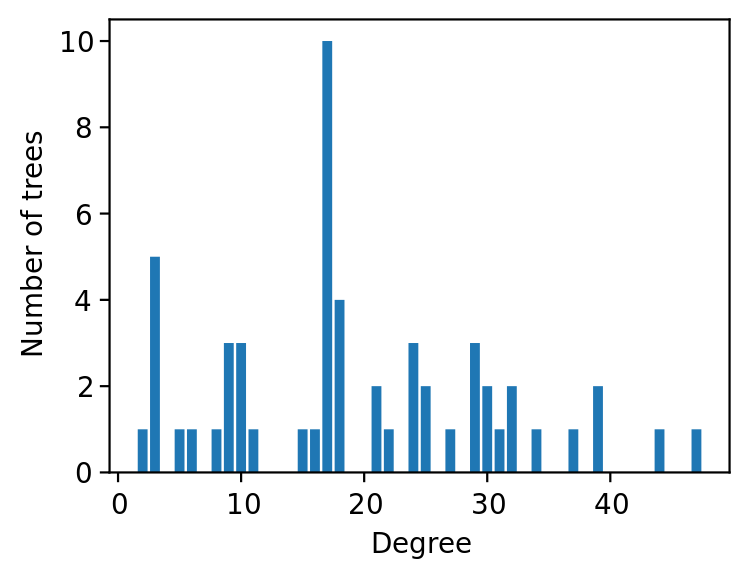

In [206]:
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = fig.add_subplot()
ax.bar(*np.unique(sorted(degrees, reverse=True), return_counts=True))
ax.set_xlabel("Degree")
ax.set_ylabel("Number of trees")
plt.show()